In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/FIX.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,12.51,12.68,12.24,12.45,11.569341,263100
1,1/3/2013,12.50,12.62,12.42,12.55,11.662267,73500
2,1/4/2013,12.66,12.96,12.59,12.78,11.875998,102600
3,1/7/2013,12.69,12.70,12.59,12.66,11.764485,39600
4,1/8/2013,12.64,12.77,12.46,12.54,11.652973,32500


In [3]:
from collections import deque
import random

class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate):
        self.X = tf.placeholder(tf.float32, (None, input_size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        feed_forward = tf.layers.dense(self.X, layer_size, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, output_size)
        self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.trainable = tf.trainable_variables()
    
    def _assign(self):
        for i in range(len(self.trainable)//2):
            assign_op = self.trainable[i+len(self.trainable)//2].assign(self.trainable[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.predict(states)
        Q_new = self.predict(new_states)
        Q_new_negative = self.sess.run(self.model_negative.logits, feed_dict={self.model_negative.X:new_states})
        replay_size = len(replay)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, done_r = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not done_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
        return X, Y

    def predict(self, inputs):
        return self.sess.run(self.model.logits, feed_dict={self.model.X:inputs})
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign()
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                state = next_state
                X, Y = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.model.cost, self.model.optimizer], 
                                        feed_dict={self.model.X: X, self.model.Y:Y})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 10, total rewards: 904.610003.3, cost: 0.010365, total money: 10904.610003
epoch: 20, total rewards: 330.919972.3, cost: 0.004232, total money: 10028.409970
epoch: 30, total rewards: 355.460038.3, cost: 0.009859, total money: 10254.400037
epoch: 40, total rewards: 203.270081.3, cost: 0.000652, total money: 10001.880078
epoch: 50, total rewards: 95.559954.3, cost: 0.007949, total money: 10045.429953
epoch: 60, total rewards: 250.730011.3, cost: 0.000530, total money: 10099.450009
epoch: 70, total rewards: 0.250056.3, cost: 0.001645, total money: 10000.250056
epoch: 80, total rewards: 46.070015.3, cost: 0.001502, total money: 10046.070015
epoch: 90, total rewards: 42.200006.3, cost: 0.000819, total money: 10042.200005
epoch: 100, total rewards: -8.160017.3, cost: 0.001145, total money: 9941.709982
epoch: 11

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 12.780000, total balance 9987.220000
day 10: buy 1 unit at price 12.430000, total balance 9974.790000
day 20, sell 1 unit at price 12.910000, investment 1.017215 %, total balance 9987.700000,
day 24: buy 1 unit at price 11.900000, total balance 9975.800000
day 28, sell 1 unit at price 12.140000, investment -2.333065 %, total balance 9987.940001,
day 29, sell 1 unit at price 12.170000, investment 2.268912 %, total balance 10000.110001,
day 33: buy 1 unit at price 12.400000, total balance 9987.710001
day 35, sell 1 unit at price 12.770000, investment 2.983878 %, total balance 10000.480001,
day 43: buy 1 unit at price 12.820000, total balance 9987.660002
day 48: buy 1 unit at price 12.870000, total balance 9974.790002
day 54: buy 1 unit at price 13.780000, total balance 9961.010002
day 61: buy 1 unit at price 13.320000, total balance 9947.690002
day 62, sell 1 unit at price 13.240000, investment 3.276132 %, total balance 9960.930002,
day 63: buy 1 unit at price 

day 523, sell 1 unit at price 16.650000, investment 25.660374 %, total balance 9921.589998,
day 526, sell 1 unit at price 17.709999, investment 21.384502 %, total balance 9939.299997,
day 531, sell 1 unit at price 16.680000, investment 6.649616 %, total balance 9955.979998,
day 535: buy 1 unit at price 17.230000, total balance 9938.749998
day 539: buy 1 unit at price 16.850000, total balance 9921.899998
day 558, sell 1 unit at price 19.830000, investment 32.553475 %, total balance 9941.729998,
day 560, sell 1 unit at price 19.670000, investment 29.663810 %, total balance 9961.399998,
day 561, sell 1 unit at price 20.290001, investment 30.650362 %, total balance 9981.689999,
day 563, sell 1 unit at price 21.180000, investment 26.221689 %, total balance 10002.869999,
day 564: buy 1 unit at price 21.040001, total balance 9981.829998
day 568: buy 1 unit at price 20.139999, total balance 9961.689999
day 569, sell 1 unit at price 20.299999, investment 17.817758 %, total balance 9981.989998,


day 885: buy 1 unit at price 33.430000, total balance 10082.939993
day 886, sell 1 unit at price 33.480000, investment 0.149564 %, total balance 10116.419992,
day 889: buy 1 unit at price 32.099998, total balance 10084.319994
day 892, sell 1 unit at price 31.080000, investment -3.177566 %, total balance 10115.399994,
day 893: buy 1 unit at price 31.490000, total balance 10083.909994
day 900, sell 1 unit at price 30.379999, investment -3.524931 %, total balance 10114.289993,
day 902: buy 1 unit at price 29.139999, total balance 10085.149994
day 906, sell 1 unit at price 28.410000, investment -2.505146 %, total balance 10113.559994,
day 907: buy 1 unit at price 28.820000, total balance 10084.739994
day 911: buy 1 unit at price 29.209999, total balance 10055.529995
day 915, sell 1 unit at price 28.639999, investment -0.624567 %, total balance 10084.169994,
day 918: buy 1 unit at price 29.020000, total balance 10055.149994
day 919, sell 1 unit at price 29.120001, investment -0.308108 %, to

day 1496: buy 1 unit at price 46.799999, total balance 9635.439985
day 1502: buy 1 unit at price 43.200001, total balance 9592.239985
day 1503, sell 1 unit at price 42.950001, investment -17.292508 %, total balance 9635.189985,
day 1504, sell 1 unit at price 41.470001, investment -20.249998 %, total balance 9676.659987,
day 1506, sell 1 unit at price 43.279999, investment -19.568858 %, total balance 9719.939985,
day 1507, sell 1 unit at price 42.720001, investment -21.325964 %, total balance 9762.659987,
day 1510, sell 1 unit at price 43.459999, investment -23.201981 %, total balance 9806.119986,
day 1512, sell 1 unit at price 44.689999, investment -21.527659 %, total balance 9850.809984,
day 1519: buy 1 unit at price 47.900002, total balance 9802.909983
day 1531, sell 1 unit at price 47.279999, investment -14.964029 %, total balance 9850.189981,
day 1533: buy 1 unit at price 48.590000, total balance 9801.599981
day 1535, sell 1 unit at price 47.860001, investment -8.173443 %, total ba

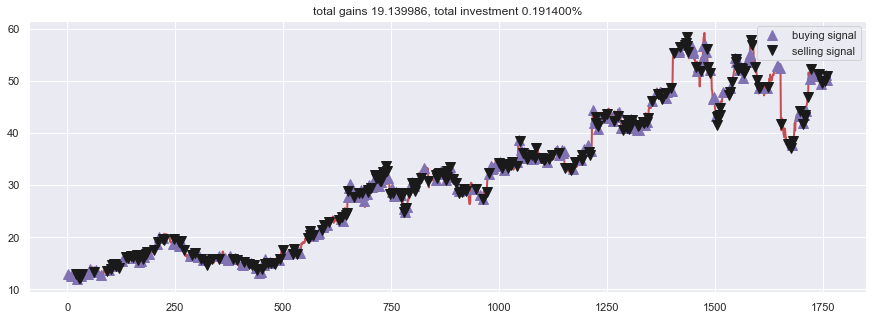

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()